# Prediction - Wheat Calibration

Artificial Neural Network based on a TensorFlow / Keras model

Reads Protein.h5 and Moisture.h5 models for prediction purposes

### Import Libraries
`tensorflow`, `numpy`, `pandas`, `matplotlib`, `sklearn`

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import pickle

### Import Models

In [3]:
pkl_filename = "./Model/pickle_pca_model.pkl"
with open(pkl_filename, 'rb') as file:
    pca = pickle.load(file)
    
pkl_filename = "./Model/pickle_scaler_model.pkl"
with open(pkl_filename, 'rb') as file:
    scaler = pickle.load(file)
    
model1 = load_model('./Model/Protein.h5')
model2 = load_model('./Model/Moisture.h5')
Cal1Name = "Protein"
Cal2Name = "Moisture"
Cal3Name = "Oil"

In [4]:
#Testing Data
path = "./Data/(3) Testing/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_test = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3"
df_test = df_test.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_test = df_test.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})

#Drop values of spectra if NaN
for i in range(9,33):
    df_test = df_test.dropna(subset=["Sp{}".format(i)])
    
#Drop values of protein if NaN
df_test = df_test.dropna(subset=[Cal1Name])

test_spectra = df_test.loc[:,"Sp9":"Sp33"].values
                         
test_values = [1,2,3]
if Cal1Name in df_test:
    test_values[0] = df_test[Cal1Name].values
if Cal2Name in df_test:
    test_values[1] = df_test[Cal2Name].values
if Cal3Name in df_test:
    test_values[2] = df_test[Cal3Name].values

test_spectra_pca = pca.transform(test_spectra)

test_spectra_pca = scaler.transform(test_spectra_pca)

prediction = [1,2]
prediction[0] = model1.predict(test_spectra_pca)
prediction[1] = model2.predict(test_spectra_pca)

In [5]:
print("Lab Values {} = {}".format(Cal1Name, test_values[0]))
print("Prediction {} = {}\n".format(Cal1Name, np.around(prediction[0].reshape(test_values[0].shape[0]),decimals=1)))
print("Lab Values {} = {}".format(Cal2Name, test_values[1]))
print("Prediction {} = {}".format(Cal2Name, np.around(prediction[1].reshape(test_values[1].shape[0]),decimals=1)))

Lab Values Protein = [ 9.2  9.2 10.4 10.4 11.3 11.3 12.2 12.2 12.9 12.9 13.4 13.4 14.3 14.3
 15.2 15.2 16.2 16.2]
Prediction Protein = [10.7 10.8 11.3 11.4 12.4 12.7 13.2 13.1 14.5 14.5 14.3 14.3 15.4 15.3
 16.6 16.5 17.3 17.2]

Lab Values Moisture = [11.  11.   9.6  9.6 10.6 10.6  9.8  9.8  9.8  9.8 11.1 11.1 11.6 11.6
  9.9  9.9  9.3  9.3]
Prediction Moisture = [11.  11.   9.4  9.4 10.1 10.1  9.5  9.5  9.5  9.5 11.1 11.1 11.4 11.4
  9.8  9.7  9.4  9.5]


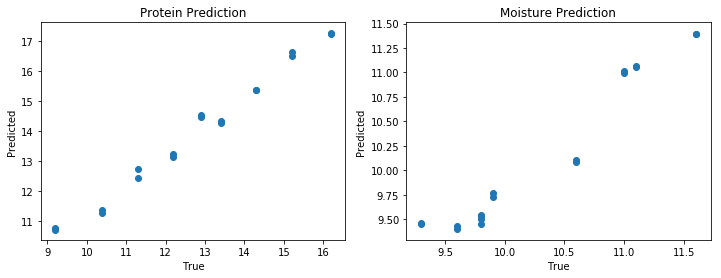

In [6]:
plt.rcParams['figure.figsize'] = (12.0, 4.0) # set default size of plots
plt.subplot(121)
plt.scatter(test_values[0], prediction[0])
plt.title('Protein Prediction')
plt.ylabel('Predicted')
plt.xlabel('True')

plt.subplot(122)
plt.scatter(test_values[1], prediction[1])
plt.title('Moisture Prediction')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [7]:
def PrintResults(Name, constituent, useSlope = True, slope = 1.0):    
    print("Results for {}".format(Name))    

    if useSlope:
        LR_X = prediction[constituent][:,0].reshape(prediction[constituent][:,0].shape[0],1)
        LR_y = test_values[constituent].reshape(test_values[constituent].shape[0],1)
        reg = LinearRegression().fit(LR_X, LR_y)
        print ("R2 = " + str(reg.score(LR_X, LR_y)))

        print("Slope = " + str(reg.coef_))
        print("Bias = " + str(reg.intercept_))
        predictionAdjusted = prediction[constituent][:,0] * reg.coef_ + reg.intercept_
        predictionAdjusted = predictionAdjusted[0]
        
    else:
        predictionAdjusted = prediction[constituent][:,0] * slope
        bias = np.mean(predictionAdjusted - test_values[constituent])
        predictionAdjusted = predictionAdjusted - bias
        print("Slope = " + str(slope))
        print("Bias = " + str(-bias))
        
    print("Lab Values = {}".format(np.round(test_values[constituent],1)))
    print("Prediction = {}".format(np.round(predictionAdjusted,1)))

    error = (predictionAdjusted - test_values[constituent])
    print("Error = {}".format(np.round(error,2)))

    sep = error.std()
    print("Standard Deviation = " + str(sep))
    
    plt.plot(error)
    plt.title('Prediction Error')
    plt.ylabel('Error %')
    plt.show()

Results for Protein
R2 = 0.9853972028051203
Slope = [[1.012549]]
Bias = [-1.3625708]
Lab Values = [ 9.2  9.2 10.4 10.4 11.3 11.3 12.2 12.2 12.9 12.9 13.4 13.4 14.3 14.3
 15.2 15.2 16.2 16.2]
Prediction = [ 9.5  9.6 10.  10.1 11.2 11.5 12.  11.9 13.3 13.3 13.2 13.1 14.2 14.2
 15.5 15.3 16.1 16.1]
Error = [ 0.3   0.35 -0.35 -0.25 -0.07  0.24 -0.17 -0.26  0.44  0.38 -0.25 -0.33
 -0.1  -0.12  0.27  0.13 -0.07 -0.13]
Standard Deviation = 0.25876656466617654


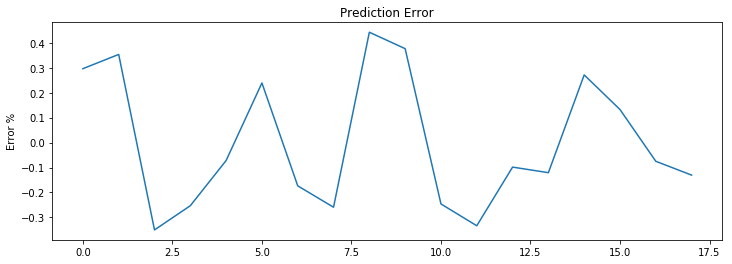

In [8]:
PrintResults(Cal1Name,0)

Results for Moisture
Slope = 1.0
Bias = 0.16857159932454438
Lab Values = [11.  11.   9.6  9.6 10.6 10.6  9.8  9.8  9.8  9.8 11.1 11.1 11.6 11.6
  9.9  9.9  9.3  9.3]
Prediction = [11.2 11.2  9.6  9.6 10.2 10.3  9.7  9.6  9.7  9.7 11.2 11.2 11.6 11.6
  9.9  9.9  9.6  9.6]
Error = [ 0.18  0.16  0.   -0.03 -0.35 -0.33 -0.13 -0.18 -0.09 -0.1   0.14  0.12
 -0.03 -0.04  0.03 -0.01  0.32  0.33]
Standard Deviation = 0.18342923219350082


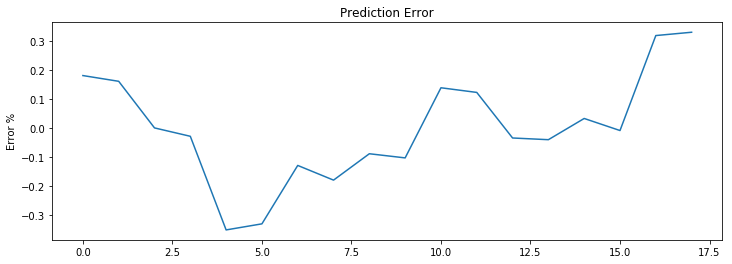

In [9]:
PrintResults(Cal2Name,1,False)